In [1]:
####### All Imports #######
import warnings
warnings.filterwarnings("ignore")

import re
import os
import random
from datetime import datetime

import librosa
from scipy.io import wavfile
import numpy as np
import pandas as pd
import sklearn as sk
import torch
from torch.utils import data
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
####### Setup Environment #######

# enable GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# (tf v2) - allowing GPU memory growth.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
      # Memory growth must be set before GPUs have been initialized
      print(e)

#keras saving/loading issue attempt?
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
# manual_variable_initialization(True)

In [3]:
####### Configs for Machine Learning #######

### Loading Test/Training Data ###
load_urbansound_data = True # <-- Note: Urbansound8k has a shortcut for testing/debugging, only loads 1 folder (800 instead of 8000)
# Data Source: https://urbansounddataset.weebly.com/urbansound8k.html
load_birds_data      = False
# Data Source: https://machine-listening.eecs.qmul.ac.uk/bird-audio-detection-challenge/#downloads
load_kaggle_data     = False
load_kaggle_all_data = False
# Data Source: https://www.kaggle.com/mmoreaux/environmental-sound-classification-50#esc50.csv
load_kaggle_cats_dogs_data  = False
# Data Source:  https://www.kaggle.com/mmoreaux/audio-cats-and-dogs
load_freesound_data = False
# Data Source:  https://www.kaggle.com/c/freesound-audio-tagging/data
load_audioset_data   = False
# Data Source: https://research.google.com/audioset/index.html
# See scripts/README.md for downloading & filtering instructions.

trimmed_only = False
# Only use wav files that end with extension '-processed.wav'


### Loading/Saving Model ###
save_numpy = 'urban-sounds' # False = do nothing. String = Saves only features/labels into a .npy file within /data directory
load_numpy = False # False = load direct from wav files (SLOW). String = load features/labels from a .npy file
# save_numpy = False # all_data_<name.npy> and all_labels_<name.npy>
# load_numpy = "kaggle50.npy" # all_data_<name.npy> and all_labels_<name.npy>

load_model_file = False #"all_data_attempt" # False = create new model, String = load pre-trian model from filename (no filename extension).
save_model_file = False #"all_data_attempt" # False = do nothing, String = save trained model to filename (no filename extension).
# save_model_file = "urbansound_first_try" 
# load_model_file = "urbansound_first_try"


### Training / Fitting / Optimizing Model #####
test_size = 0.2
epochs    = 60
batch_size= 4
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

do_model_analysis = False

In [4]:
####### HELPER FUNCTIONS (Table of Content) #######
# extract_features()
# display_wav()
# load_all_wav_files()
#    load_urbansound
#    load_birds
#    load_kaggle
#    load_kaggle_cats_dogs
#    load_audioset_data
# analyze_features()
# plot_history() loss & accuracy v epochs)
# plot_confusion_matrix()

In [5]:
def extract_features(file_name):
    """
    Extracts 193 chromatographic features from sound file. 
    including: MFCC's, Chroma_StFt, Melspectrogram, Spectral Contrast, and Tonnetz
    NOTE: this extraction technique changes the time series nature of the data
    """
    features = []
    
    audio_data, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(audio_data))
    
    mfcc = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40).T,axis=0)
    features.extend(mfcc) # 40 = 40
    
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    features.extend(chroma) # 12 = 52
    
    mel = np.mean(librosa.feature.melspectrogram(audio_data, sr=sample_rate).T,axis=0)
    features.extend(mel) # 128 = 180
    
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    features.extend(contrast) # 7 = 187

# More possible features to add
#     tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X, ), sr=sample_rate).T,axis=0)
#     spec_cent = np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate).T, axis=0)
#     spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate).T, axis=0)
#     rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate).T, axis=0)
#     zcr = np.mean(librosa.feature.zero_crossing_rate(audio_data).T, axis=0)
#     features.extend(tonnetz) # 6 = 193
#     features.extend(spec_cent)
#     features.extend(spec_bw)
#     features.extend(rolloff)
#     features.extend(zcr)

    return np.array(features)

In [46]:
def display_wav(file = None):
    # Displays comparison of loading a wav file via librosa vs via scipy
    if not file:
        print("No wav file to display")
        return
    librosa_load, librosa_sampling_rate = librosa.load(file)
    scipy_sampling_rate, scipy_load = wavfile.read(file)
    print('original sample rate:',scipy_sampling_rate)
    print('converted sample rate:',librosa_sampling_rate)
    print('\n')
    print('original wav file min~max range:',np.min(scipy_load),'~',np.max(scipy_load))
    print('converted wav file min~max range:',np.min(librosa_load),'~',np.max(librosa_load))
    plt.figure(figsize=(12, 4))
    plt.plot(scipy_load)
    plt.figure(figsize=(12, 4))
    plt.plot(librosa_load)

In [6]:
urban_sounds_df = None
env_sounds_df = None
cat_dog_df = None
def load_all_wav_files(load_urbansound=False,
                       load_birds=False,
                       load_kaggle=False,
                       load_kaggle_all=False,
                       load_kaggle_cats_dogs=False,
                       load_freesound=False,
                       load_audioset=False,
                       trimmed_only=False):
    '''
    Returns two numpy array
    The first is a numpy array containing each audio's numerical features - see extract_features()
    The second numpy array is the array *STRING* of the label.
    (The array indexes align up between the two arrays. data[idx] is classified as labels[idx]) 
    '''
    one_file = None
    #THIS WILL TAKE A WHILE!!!!!
    all_data = []
    all_labels = []
    all_files = []
    #UltraSound8K
    if load_urbansound:
        print("loading Ultrasound8k")
        # Data Source: https://urbansounddataset.weebly.com/urbansound8k.html
        global urban_sounds_df
        urban_sounds_df = pd.read_csv("./data/UrbanSound8K/metadata/UrbanSound8K.csv")
        for root, dirs, files in os.walk("./data/UrbanSound8K"):
            print(root, str(len(dirs)), str(len(files)), len(all_data))
#SHORTCUT
# This is in here for quick tests - only loads first Ultrasound8k folder (instead of all of them)
#             if len(all_data) > 0: 
#                 break
#END SHORTCUT
            for idx, file in enumerate(files):
                if file.endswith('.wav'):
                    fname = os.path.join(root, file)
                    if(len(all_data) % 100 == 0):
                        print(str(len(all_data)))
                    features = extract_features(fname)
                    if trimmed_only:
                        if file.endswith('-processed.wav'):
                            file = file.replace('-processed', '')
                        else:
                            continue
                    label = urban_sounds_df[urban_sounds_df.slice_file_name == file]["class"].tolist()[0]
#                     if(label == "dog_bark"):
                    all_data.append(features)
                    all_labels.append(label)
                    one_file = fname
                    all_files.append(fname)
#                     display_wav(fname)
#                     break


    if load_birds:
        print("Loading birds")
        # Data Source: http://dcase.community/challenge2018/task-bird-audio-detection
        # Data Source: http://machine-listening.eecs.qmul.ac.uk/bird-audio-detection-challenge/#downloads
        for root, dirs, files in os.walk("./data/warblrb10k_public_wav/train/hasbird"):
            print(root, str(len(dirs)), str(len(files)), len(all_data))
            for file in files:
                if file.endswith('.wav'):
                    fname = os.path.join(root, file)
                    if(len(all_data) % 100 == 0):
                        print(str(len(all_data)))
                    features = extract_features(fname)
                    all_data.append(features)
                    all_labels.append("chirping_birds")
                    all_files.append(fname)


    if load_kaggle or load_kaggle_all:
        print("Loading Kaggle")
        # Data Source: https://www.kaggle.com/mmoreaux/environmental-sound-classification-50#esc50.csv
        global env_sounds
        env_sounds_df = pd.read_csv("./data/environmental-sound-classification-50/esc50.csv")
        for root, dirs, files in os.walk("./data/environmental-sound-classification-50/"):
            for file in files:
        #for file in os.listdir("./data/environmental-sound-classification-50/audio"):
        #    fname = "./data/environmental-sound-classification-50/audio/"+file
                if trimmed_only and not file.endswith('-processed.wav'):
                    continue
                if file.endswith('.wav'):
                    fname = os.path.join(root, file)
                    if trimmed_only:
                        if file.endswith('-processed.wav'):
                            file = file.replace('-processed', '')
                        else:
                            continue
                    label = env_sounds_df[env_sounds_df.filename == file]["category"].tolist()[0]
                    
                    animals=["cat", "chirping_birds","cow","crickets","crow","dog","frog","hen","insects","pig","rooster","sheep"]
                    if label in animals or load_kaggle_all:
                        if(len(all_data) % 100 == 0):
                            print(str(len(all_data)))
                        features = extract_features(fname)
                        all_data.append(features)
                        all_labels.append(label)
                        all_files.append(fname)

    if load_kaggle_cats_dogs:
        print("Loading Kaggle cats and dogs")
        # Data Source:  https://www.kaggle.com/mmoreaux/audio-cats-and-dogs
        global cat_dog_df
        cat_dog_df = pd.read_csv("./data/kaggle_cats_dogs/train_test_split.csv")
        for file in os.listdir("./data/kaggle_cats_dogs/cats_dogs"):
            fname = "./data/kaggle_cats_dogs/cats_dogs/"+file
            if file.endswith('.wav'):
                if trimmed_only:
                    if file.endswith('-processed.wav'):
                        file = file.replace('-processed', '')
                    else:
                        continue
                if(len(all_data) % 100 == 0):
                    print(str(len(all_data)))
                features = extract_features(fname)
                all_data.append(features)
                label = 'cat' if file.startswith('cat') else 'dog'
                all_labels.append(label)
                all_files.append(fname)
#                 one

    if load_freesound:
        print("Loading Freesound")
        # Data Source:  https://www.kaggle.com/c/freesound-audio-tagging/data
        metadata_train = pd.read_csv('./data/freesound-audio-tagging/train_post_competition.csv')
        metadata_test  = pd.read_csv('./data/freesound-audio-tagging/test_post_competition.csv')
        metadata_test = metadata_test[metadata_test.label != 'None']
        for root, dirs, files in os.walk("./data/freesound-audio-tagging/"):
            for file in files:
                if file.endswith('.wav'):
                    fname = os.path.join(root, file)
                    if trimmed_only:
                        if file.endswith('-processed.wav'):
                            file = file.replace('-processed', '')
                        else:
                            continue
                    if "audio_train" in fname:
                        try:
                            label = metadata_train[metadata_train['fname'] == file]["label"].tolist()[0]
                        except:
                            continue
                    elif "audio_test" in fname:
                        try:
                            label = metadata_test[metadata_test['fname'] == file]["label"].tolist()[0]
                        except:
                            continue
                    else:
                        continue

                    if(len(all_data) % 100 == 0):
                        print(str(len(all_data)))
                    features = extract_features(fname)
                    all_data.append(features)
                    all_labels.append(label)
                    all_files.append(fname)



                
    if load_audioset:
        err_files = []
        # Data Source: https://research.google.com/audioset/index.html
        # See scripts/README.md for downloading & filtering instructions.
        print("Loading Audioset")
        metadata_b = pd.read_csv("./data/audioset/balanced_train_segments-animals.csv")
        metadata_e = pd.read_csv("./data/audioset/eval_segments-animals.csv")
        metadata_l = pd.read_csv("./data/audioset/class_labels_indices-animals.csv")
#         print("METADATA BALANCED", metadata_b.head())
#         print("METADATA EVAL", metadata_e.head())
#         print("METADATA LABEL", metadata_l.head())
        for root, dirs, files in os.walk("./data/audioset"):
            print(root, str(len(dirs)), str(len(files)), len(all_data))
            for idx, file in enumerate(files):
                if file.endswith('.wav'):
                    if(len(all_data) % 100 == 0):
                        print(str(len(all_data)))
                    fname = os.path.join(root, file)
                    try:
                        features = extract_features(fname)
                    except ValueError as err:
                        # Errors out on files that are empty or nearly empty
                        err_files.append(fname)
                        continue
#                     file_id = file.replace(".wav", "")
                    fid = re.sub(r'_[\d\.]+wav$','',file)
                    temp = None
                    if "balanced_train_segments" in fname:
#                         temp = metadata_b[metadata_b['# YTID'] == no_ext]["Unnamed: 3"].tolist()
                        temp = metadata_b[metadata_b['# YTID'] == fid]["Unnamed: 3"].tolist()
                    elif "eval_segments" in fname:
#                         temp = metadata_e[metadata_e['# YTID'] == no_ext]["Unnamed: 3"].tolist()
                        temp = metadata_e[metadata_e['# YTID'] == fid]["Unnamed: 3"].tolist()
                    if not temp:
                        continue
                    label_code = temp[0]
                    label_temp = metadata_l[metadata_l.mid == label_code]["display_name"].to_list()
                    if not label_temp:
                        continue
                    label = label_temp[0]
                    
                    all_data.append(features)
                    all_labels.append(label)
                    all_files.append(fname)
                    if(len(all_data) >= 1000):
                        break
        if err_files:
            print("{} ERROR FILES:\n {}".format(len(err_files), err_files))
        
    
    return np.array(all_data), np.array(all_labels), all_files, one_file

In [7]:
def analyze_features(all_data, all_labels):
    #seeking only the numeric features from the data
    numeric_features = all_data.select_dtypes(include = [np.number])
    print(numeric_features.dtypes)
    corr = numeric_features.corr()
    print(corr)
#     print(corr['SalePrice'].sort_values(ascending = False)[:5], '\n')
#     print(corr['SalePrice'].sort_values(ascending = False)[-5:])

In [8]:
def plot_history(history = None):
    # Plots accuracy & loss versus epochs
    if not history:
        print("No history to plot")
        return
    fig = plt.figure(figsize=(10,8))
#     fig = plt.figure(figsize=(20,16))
    plt.plot(history.history['loss'], label="Loss")
    plt.plot(history.history['accuracy'], label="Accuracy")
    plt.axis([0,90,0,1.1])
    plt.title("Accuracy and Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Percentage")
    plt.legend()
    plt.show()

In [90]:
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes,
           yticklabels=classes,
           title="Confusion Matrix for Model 5",
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_ylim(len(classes)-0.5, -0.5)
    ax.set_aspect('auto')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.grid(None)
    plt.show()

In [10]:
all_data = np.array([])
all_labels = np.array([])
one_file = None
if not load_numpy:
    all_data, all_labels, all_files, one_file = load_all_wav_files(load_urbansound_data,
                                          load_birds_data,
                                          load_kaggle_data,
                                          load_kaggle_all_data,
                                          load_kaggle_cats_dogs_data,
                                          load_freesound_data,
                                          load_audioset_data,
                                          trimmed_only)
else:
    all_data = np.load("data/all_data_"+load_numpy)
    all_labels = np.load("data/all_labels_"+load_numpy)
if save_numpy:
    np.save("data/all_data_"+save_numpy, all_data)
    np.save("data/all_labels_"+save_numpy, all_labels)
# # display_wav(one_file)

loading Ultrasound8k
./data/UrbanSound8K 2 3 0
./data/UrbanSound8K/audio 10 1 0
./data/UrbanSound8K/audio/fold2 0 889 0
0
100
200
300
400
500
600
700
800
./data/UrbanSound8K/audio/fold5 0 937 888
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
./data/UrbanSound8K/audio/fold4 0 991 1824
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
./data/UrbanSound8K/audio/fold3 0 926 2814
2900
3000
3100
3200
3300
3400
3500
3600
3700
./data/UrbanSound8K/audio/fold8 0 807 3739
3800
3900
4000
4100
4200
4300
4400
4500
./data/UrbanSound8K/audio/fold6 0 824 4545
4600
4700
4800
4900
5000
5100
5200
5300
./data/UrbanSound8K/audio/fold1 0 874 5368
5400
5500
5600
5700
5800
5900
6000
6100
6200
./data/UrbanSound8K/audio/fold7 0 839 6241
6300
6400
6500
6600
6700
6800
6900
7000
./data/UrbanSound8K/audio/fold9 0 817 7079
7100
7200
7300
7400
7500
7600
7700
7800
./data/UrbanSound8K/audio/fold10 0 838 7895
7900
8000
8100
8200
8300
8400
8500
8600
8700
./data/UrbanSound8K/metadata 0 2 8732


In [11]:
print(all_data.shape)
classes = list(set(all_labels)) # classes = unique list of labels
n_classes = len(classes)
numeric_labels = np.array([classes.index(label) for label in all_labels]) # labels by index
print(classes)
#all_data_copy = all_data.copy()
#all_labels_copy = all_labels.copy()

(8732, 187)
['street_music', 'children_playing', 'gun_shot', 'air_conditioner', 'car_horn', 'jackhammer', 'dog_bark', 'siren', 'drilling', 'engine_idling']


In [12]:
for entry in classes:
    print(entry)

street_music
children_playing
gun_shot
air_conditioner
car_horn
jackhammer
dog_bark
siren
drilling
engine_idling


In [13]:
def get_unique_labels(in_labels):
    temp_df = pd.DataFrame({ 'labels': all_labels })
    temp_df['labels'] = temp_df['labels'].str.lower()
    
    temp_df.loc[temp_df['labels'] == 'dog_bark'] = 'dog'
    temp_df.loc[temp_df['labels'] == 'bark'] = 'dog'
    temp_df.loc[temp_df['labels'] == 'meow'] = 'cat'
    temp_df.loc[temp_df['labels'] == 'cough'] = 'coughing'
    temp_df.loc[temp_df['labels'] == 'laughing'] = 'laughter'
    temp_df.loc[temp_df['labels'] == 'gun_shot'] = 'gunshot_or_gunfire'
    # Not sure I should do this one
    # temp_df.loc[temp_df['labels'] == 'engine_idling'] = 'engine'
    # temp_df.loc[temp_df['labels'] == 'jackhammer'] = 'drilling'
    # temp_df.loc[temp_df['labels'] == 'water_drops'] = 'pouring_water'
    return temp_df['labels'].to_numpy()

In [14]:
###### COLT REMOVE THIS ######
# all_labels = get_unique_labels(all_labels)
print(all_data.shape)
classes = list(set(all_labels)) # classes = unique list of labels
n_classes = len(classes)
numeric_labels = np.array([classes.index(label) for label in all_labels]) # labels by index
print(classes)

(8732, 187)
['street_music', 'children_playing', 'gun_shot', 'air_conditioner', 'car_horn', 'jackhammer', 'dog_bark', 'siren', 'drilling', 'engine_idling']


In [19]:
all_data_df = pd.DataFrame(data=all_data[:,:])
all_data_df.insert(0, "WAV", all_files, True)
all_data_df.insert(0, "label", numeric_labels, True)

#all_data_df.set_index('WAV', inplace=True)
print(all_data_df.shape)
print(all_data_df.head())

(8732, 189)
      label                                                WAV           0  \
3329      1    ./data/UrbanSound8K/audio/fold3/58857-2-0-7.wav -296.336426   
866       7   ./data/UrbanSound8K/audio/fold2/102871-8-0-4.wav -170.340927   
3992      0   ./data/UrbanSound8K/audio/fold8/41364-9-0-24.wav -211.549850   
8140      1  ./data/UrbanSound8K/audio/fold10/197554-2-0-23... -410.646667   
2517      6    ./data/UrbanSound8K/audio/fold4/95404-3-0-5.wav -487.329987   

               1          2          3          4          5          6  \
3329  121.987770 -55.234566 -22.852829  -8.925958 -11.813898 -13.471021   
866   120.888664 -64.219223   4.627699 -18.900095  11.043585 -17.594131   
3992   92.664398  -3.559243  13.020376   7.647224   7.758419  -0.474698   
8140   80.607956 -17.488359  26.150696  18.957569  20.766939  23.116720   
2517  120.244019  -7.870072  -8.565516 -22.716959   3.501578  -3.118493   

              7  ...       177           178           179        18

In [51]:
urban_sounds_df.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [54]:
models = []
for i in range(10):
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    for j in range(10):
        temp_df = all_data_df[all_data_df['WAV'].str.contains('fold'+str(j+1))]
        if i == j:
            test_data = temp_df
        else:        
            if train_data.empty:
                train_data = temp_df
            else:
                train_data = train_data.append(temp_df)
    
    x_train = train_data.iloc[:, 2:].to_numpy()
    x_test = test_data.iloc[:, 2:].to_numpy()
    
    y_train = train_data.iloc[:, [0]].to_numpy()
    y_test = test_data.iloc[:, [0]].to_numpy()
    
    model = Sequential()
    model.add(Dense(256, activation='relu',  input_dim=x_train.shape[1]))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_classes, activation='softmax')) # sigmoid
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
        
    history = model.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
                        verbose=2)
    models.append({'model':model, 'history': history, 'xtrain': x_train, 'ytrain': y_train, 'xtest': x_test, 'ytest': y_test})

Train on 7859 samples, validate on 1710 samples
Epoch 1/60
 - 2s - loss: 1.6673 - accuracy: 0.5259 - val_loss: 1.6707 - val_accuracy: 0.5819
Epoch 2/60
 - 2s - loss: 0.9545 - accuracy: 0.7002 - val_loss: 1.5058 - val_accuracy: 0.6298
Epoch 3/60
 - 3s - loss: 0.7326 - accuracy: 0.7692 - val_loss: 1.5873 - val_accuracy: 0.6690
Epoch 4/60
 - 2s - loss: 0.6017 - accuracy: 0.8114 - val_loss: 1.8772 - val_accuracy: 0.6620
Epoch 5/60
 - 2s - loss: 0.5213 - accuracy: 0.8441 - val_loss: 1.9424 - val_accuracy: 0.6591
Epoch 6/60
 - 2s - loss: 0.4748 - accuracy: 0.8567 - val_loss: 1.9673 - val_accuracy: 0.6860
Epoch 7/60
 - 2s - loss: 0.4671 - accuracy: 0.8673 - val_loss: 2.2089 - val_accuracy: 0.6801
Epoch 8/60
 - 2s - loss: 0.3832 - accuracy: 0.8782 - val_loss: 1.9173 - val_accuracy: 0.7029
Epoch 9/60
 - 2s - loss: 0.3402 - accuracy: 0.8966 - val_loss: 1.8580 - val_accuracy: 0.6982
Epoch 10/60
 - 2s - loss: 0.3149 - accuracy: 0.8991 - val_loss: 2.3620 - val_accuracy: 0.7228
Epoch 11/60
 - 2s - l

Epoch 28/60
 - 3s - loss: 0.1626 - accuracy: 0.9559 - val_loss: 6.0510 - val_accuracy: 0.4921
Epoch 29/60
 - 3s - loss: 0.1440 - accuracy: 0.9589 - val_loss: 11.4020 - val_accuracy: 0.4910
Epoch 30/60
 - 3s - loss: 0.1881 - accuracy: 0.9507 - val_loss: 12.5952 - val_accuracy: 0.5000
Epoch 31/60
 - 3s - loss: 0.1340 - accuracy: 0.9620 - val_loss: 10.2297 - val_accuracy: 0.4887
Epoch 32/60
 - 3s - loss: 0.2088 - accuracy: 0.9501 - val_loss: 12.7323 - val_accuracy: 0.4921
Epoch 33/60
 - 3s - loss: 0.1967 - accuracy: 0.9639 - val_loss: 12.4555 - val_accuracy: 0.4673
Epoch 34/60
 - 3s - loss: 0.1579 - accuracy: 0.9598 - val_loss: 13.0441 - val_accuracy: 0.4786
Epoch 35/60
 - 3s - loss: 0.1428 - accuracy: 0.9595 - val_loss: 12.7817 - val_accuracy: 0.4730
Epoch 36/60
 - 3s - loss: 0.1478 - accuracy: 0.9612 - val_loss: 12.5515 - val_accuracy: 0.4955
Epoch 37/60
 - 3s - loss: 0.1537 - accuracy: 0.9634 - val_loss: 12.5894 - val_accuracy: 0.4854
Epoch 38/60
 - 3s - loss: 0.1892 - accuracy: 0.9636

Epoch 55/60
 - 2s - loss: 0.1600 - accuracy: 0.9662 - val_loss: 8.1252 - val_accuracy: 0.4886
Epoch 56/60
 - 2s - loss: 0.1275 - accuracy: 0.9680 - val_loss: 8.9163 - val_accuracy: 0.4778
Epoch 57/60
 - 2s - loss: 0.1172 - accuracy: 0.9674 - val_loss: 8.3422 - val_accuracy: 0.4984
Epoch 58/60
 - 3s - loss: 0.1358 - accuracy: 0.9652 - val_loss: 8.8519 - val_accuracy: 0.4930
Epoch 59/60
 - 3s - loss: 0.1637 - accuracy: 0.9682 - val_loss: 8.3039 - val_accuracy: 0.4714
Epoch 60/60
 - 3s - loss: 0.1134 - accuracy: 0.9697 - val_loss: 8.7166 - val_accuracy: 0.4865
Train on 8579 samples, validate on 990 samples
Epoch 1/60
 - 3s - loss: 1.5954 - accuracy: 0.5118 - val_loss: 1.4772 - val_accuracy: 0.5253
Epoch 2/60
 - 2s - loss: 0.8947 - accuracy: 0.7161 - val_loss: 1.6915 - val_accuracy: 0.5333
Epoch 3/60
 - 3s - loss: 0.6019 - accuracy: 0.8048 - val_loss: 1.9908 - val_accuracy: 0.5000
Epoch 4/60
 - 3s - loss: 0.5124 - accuracy: 0.8335 - val_loss: 2.0157 - val_accuracy: 0.5293
Epoch 5/60
 - 3s 

Epoch 22/60
 - 2s - loss: 0.1701 - accuracy: 0.9494 - val_loss: 3.3959 - val_accuracy: 0.5737
Epoch 23/60
 - 2s - loss: 0.1547 - accuracy: 0.9533 - val_loss: 3.0590 - val_accuracy: 0.5994
Epoch 24/60
 - 2s - loss: 0.1820 - accuracy: 0.9527 - val_loss: 4.6454 - val_accuracy: 0.5694
Epoch 25/60
 - 2s - loss: 0.1681 - accuracy: 0.9517 - val_loss: 4.2073 - val_accuracy: 0.5801
Epoch 26/60
 - 2s - loss: 0.1864 - accuracy: 0.9517 - val_loss: 2.9642 - val_accuracy: 0.5833
Epoch 27/60
 - 2s - loss: 0.1895 - accuracy: 0.9539 - val_loss: 4.7093 - val_accuracy: 0.5737
Epoch 28/60
 - 2s - loss: 0.1813 - accuracy: 0.9533 - val_loss: 4.0213 - val_accuracy: 0.6378
Epoch 29/60
 - 2s - loss: 0.1558 - accuracy: 0.9558 - val_loss: 4.0115 - val_accuracy: 0.5887
Epoch 30/60
 - 2s - loss: 0.1989 - accuracy: 0.9524 - val_loss: 3.3974 - val_accuracy: 0.5887
Epoch 31/60
 - 2s - loss: 0.1635 - accuracy: 0.9548 - val_loss: 2.8035 - val_accuracy: 0.6432
Epoch 32/60
 - 2s - loss: 0.1391 - accuracy: 0.9605 - val_lo

Epoch 49/60
 - 2s - loss: 0.1701 - accuracy: 0.9627 - val_loss: 7.2990 - val_accuracy: 0.5249
Epoch 50/60
 - 2s - loss: 0.1521 - accuracy: 0.9650 - val_loss: 5.7371 - val_accuracy: 0.5055
Epoch 51/60
 - 2s - loss: 0.1369 - accuracy: 0.9700 - val_loss: 6.9812 - val_accuracy: 0.5200
Epoch 52/60
 - 3s - loss: 0.1185 - accuracy: 0.9678 - val_loss: 9.4799 - val_accuracy: 0.4909
Epoch 53/60
 - 3s - loss: 0.1459 - accuracy: 0.9652 - val_loss: 9.0565 - val_accuracy: 0.5237
Epoch 54/60
 - 3s - loss: 0.1316 - accuracy: 0.9680 - val_loss: 7.4030 - val_accuracy: 0.5322
Epoch 55/60
 - 2s - loss: 0.3441 - accuracy: 0.9641 - val_loss: 8.4527 - val_accuracy: 0.5018
Epoch 56/60
 - 2s - loss: 0.1399 - accuracy: 0.9718 - val_loss: 8.4690 - val_accuracy: 0.5395
Epoch 57/60
 - 2s - loss: 0.1179 - accuracy: 0.9716 - val_loss: 9.4185 - val_accuracy: 0.5383
Epoch 58/60
 - 3s - loss: 0.1272 - accuracy: 0.9671 - val_loss: 8.5312 - val_accuracy: 0.5164
Epoch 59/60
 - 2s - loss: 0.1160 - accuracy: 0.9695 - val_lo

Epoch 16/60
 - 2s - loss: 0.2842 - accuracy: 0.9300 - val_loss: 3.6068 - val_accuracy: 0.5099
Epoch 17/60
 - 2s - loss: 0.2195 - accuracy: 0.9413 - val_loss: 4.1326 - val_accuracy: 0.5347
Epoch 18/60
 - 2s - loss: 0.1986 - accuracy: 0.9471 - val_loss: 4.2408 - val_accuracy: 0.5298
Epoch 19/60
 - 2s - loss: 0.2221 - accuracy: 0.9425 - val_loss: 4.9260 - val_accuracy: 0.5261
Epoch 20/60
 - 2s - loss: 0.1948 - accuracy: 0.9457 - val_loss: 5.0110 - val_accuracy: 0.4764
Epoch 21/60
 - 2s - loss: 0.1455 - accuracy: 0.9553 - val_loss: 4.7469 - val_accuracy: 0.5471
Epoch 22/60
 - 2s - loss: 0.1760 - accuracy: 0.9483 - val_loss: 4.5949 - val_accuracy: 0.5521
Epoch 23/60
 - 2s - loss: 0.1568 - accuracy: 0.9562 - val_loss: 4.5168 - val_accuracy: 0.4665
Epoch 24/60
 - 2s - loss: 0.2084 - accuracy: 0.9469 - val_loss: 4.0915 - val_accuracy: 0.5136
Epoch 25/60
 - 2s - loss: 0.1755 - accuracy: 0.9571 - val_loss: 4.1278 - val_accuracy: 0.5533
Epoch 26/60
 - 2s - loss: 0.1482 - accuracy: 0.9595 - val_lo

Epoch 43/60
 - 2s - loss: 0.1022 - accuracy: 0.9700 - val_loss: 12.7877 - val_accuracy: 0.6005
Epoch 44/60
 - 2s - loss: 0.1552 - accuracy: 0.9636 - val_loss: 11.0762 - val_accuracy: 0.6225
Epoch 45/60
 - 2s - loss: 0.1289 - accuracy: 0.9648 - val_loss: 13.4741 - val_accuracy: 0.6029
Epoch 46/60
 - 2s - loss: 0.1423 - accuracy: 0.9642 - val_loss: 15.0710 - val_accuracy: 0.5576
Epoch 47/60
 - 2s - loss: 0.1348 - accuracy: 0.9647 - val_loss: 14.3554 - val_accuracy: 0.6103
Epoch 48/60
 - 2s - loss: 0.1545 - accuracy: 0.9624 - val_loss: 12.3492 - val_accuracy: 0.6275
Epoch 49/60
 - 3s - loss: 0.0999 - accuracy: 0.9718 - val_loss: 11.7386 - val_accuracy: 0.6189
Epoch 50/60
 - 3s - loss: 0.2061 - accuracy: 0.9568 - val_loss: 12.4344 - val_accuracy: 0.6471
Epoch 51/60
 - 2s - loss: 0.1297 - accuracy: 0.9670 - val_loss: 12.8559 - val_accuracy: 0.6213
Epoch 52/60
 - 2s - loss: 0.1624 - accuracy: 0.9661 - val_loss: 10.0205 - val_accuracy: 0.6103
Epoch 53/60
 - 2s - loss: 0.0986 - accuracy: 0.974

## Calculate average accuracy and loss for the 10 trained models

In [92]:
total_accuracy = 0
accuracy_avg = 0

total_loss = 0
loss_avg = 0
total_by_class = []
accuracy_dict_sum = {}
cms = []

for i, keyval in enumerate(models):
    print("Model", i+1, "metrics:")
    model = keyval['model']
    x_train = keyval['xtrain']
    x_test  = keyval['xtest']
    y_train = keyval['ytrain']
    y_test  = keyval['ytest']
    score_train = model.evaluate(x_train, y_train, verbose=0)
    #print("\tTraining Accuracy:     ", score_train[1])
    #print("\tTraining Cross Entropy: %.2f" % score_train[0])

    score_test = model.evaluate(x_test, y_test, verbose=0)
    print("\tTesting Accuracy:     ", score_test[1])
    print("\tTesting Cross Entropy: %.2f" % score_test[0])
    
    total_accuracy += score_test[1]
    total_loss += score_test[0]
    
    # Create a confusion matrix for each model
    y_pred_percentages = model.predict(x_test) # predicted percentages
    y_pred = np.argmax(y_pred_percentages, axis=1) # Most prevalent prediction
    cm = confusion_matrix(y_test, y_pred)
    cms.append(cm)
    
    # Aggregrate accuracy per label
    for i, r in enumerate(cm):
        if classes[i] in accuracy_dict_sum:
            accuracy_dict_sum[classes[i]] += r[i]/np.sum(r)*100
        else: 
            accuracy_dict_sum[classes[i]] = r[i]/np.sum(r)*100
accuracy_avg = total_accuracy / len(models)
loss_avg = total_loss / len(models)
print("Average Accuracy:", accuracy_avg)
print("Average Loss:    ", loss_avg)

Model 1 metrics:
	Testing Accuracy:      0.7064327597618103
	Testing Cross Entropy: 7.02
Model 2 metrics:
	Testing Accuracy:      0.49211710691452026
	Testing Cross Entropy: 14.06
Model 3 metrics:
	Testing Accuracy:      0.4864864945411682
	Testing Cross Entropy: 8.72
Model 4 metrics:
	Testing Accuracy:      0.5252525210380554
	Testing Cross Entropy: 6.80
Model 5 metrics:
	Testing Accuracy:      0.5950854420661926
	Testing Cross Entropy: 5.15
Model 6 metrics:
	Testing Accuracy:      0.5078979134559631
	Testing Cross Entropy: 8.65
Model 7 metrics:
	Testing Accuracy:      0.560859203338623
	Testing Cross Entropy: 7.41
Model 8 metrics:
	Testing Accuracy:      0.48759305477142334
	Testing Cross Entropy: 8.55
Model 9 metrics:
	Testing Accuracy:      0.6115196347236633
	Testing Cross Entropy: 11.25
Model 10 metrics:
	Testing Accuracy:      0.9784946441650391
	Testing Cross Entropy: 0.08
Average Accuracy: 0.5951738774776458
Average Loss:     7.768968606546696


## View average accuracy per label

In [78]:
def f(v):
    v = v / len(models)
    return v
accuracy_dict = {k: f(v) for k, v in accuracy_dict_sum.items()}

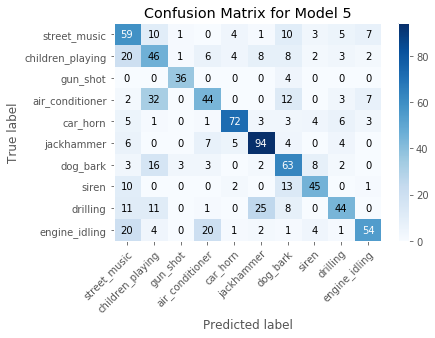

In [91]:
plot_confusion_matrix(cms[4])

In [71]:
accuracy_df = pd.DataFrame(list(accuracy_dict.items()), columns=['label', 'accuracy'])
accuracy_df.sort_values(by=['accuracy'], inplace=True, ascending=True)
accuracy_df.reset_index(inplace=True)
accuracy_df.set_index('label', inplace=True)
accuracy_df.head()

index   accuracy
label                             
air_conditioner       3  31.750000
jackhammer            5  40.814820
engine_idling         9  44.198165
drilling              8  58.600000
children_playing      1  64.900000

Text(0, 0.5, 'accuracy')

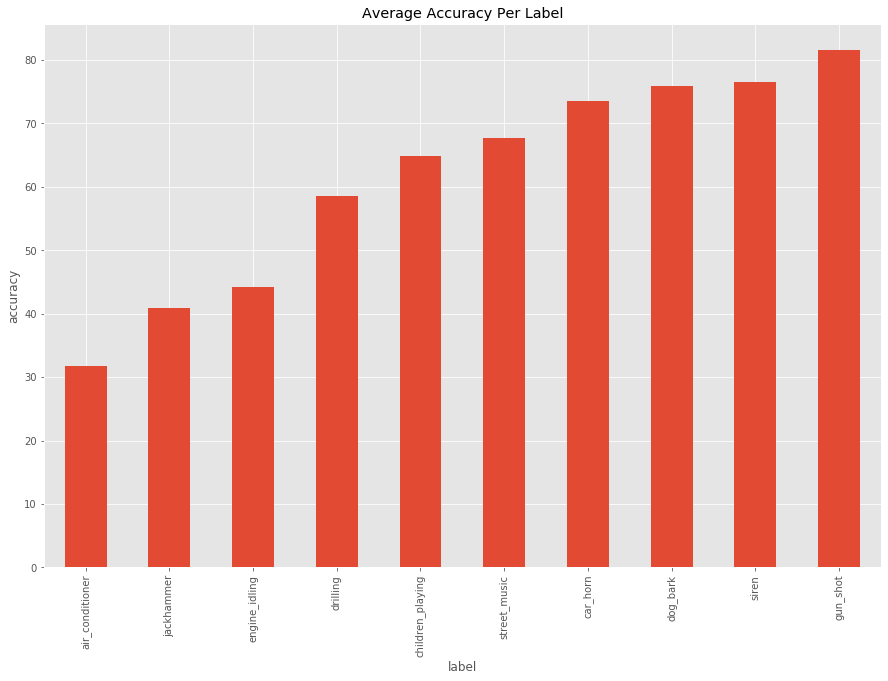

In [82]:
ax = accuracy_df['accuracy'].plot(kind="bar", title='Average Accuracy Per Label', figsize=(15,10), rot=90)
ax.set_xlabel("label")
ax.set_ylabel("accuracy")

In [83]:
guessing_accuracy = 1/len(classes)
print("Total labels:",  accuracy_df.shape[0])
print("Labels with accuracy < 1/len(labels):", accuracy_df[accuracy_df['accuracy'] <= guessing_accuracy].shape[0])

Total labels: 10
Labels with accuracy < 1/len(labels): 0


In [84]:
x_test_df_other = x_test_df.reset_index()
mispredicts = list()
for i, pred in enumerate(y_pred):
    if y_pred[i] != y_test[i]:
        print("Mipredicted file:", x_test_df_other.iloc[i]['WAV'])
        mispredicts.append(x_test_df_other.iloc[i]['WAV'])

NameError: name 'x_test_df' is not defined

In [76]:
# See what label I was most often mispredicted as
#fart_idx = int(accuracy_df.loc['coughing']['index'])
#temp_list = list(cm[fart_idx])
#print(len(temp_list))
#temp_list[fart_idx] = 0
#print(len(temp_list))
#m = max(temp_list)
#print([i for i, j in enumerate(temp_list) if j == m])

In [95]:
import IPython.display as ipd
ipd.Audio(mispredicts[1])

In [83]:
def plot_wav(wav_file, label=None):
    librosa_load, librosa_sampling_rate = librosa.load(wav_file)
    fig = plt.figure(figsize=(12, 4))
    #plt.title(label)
    plt.plot(librosa_load)
    plt.show()
    
for mispredict in mispredicts:
    print(mispredict)

./data/kaggle_cats_dogs/cats_dogs/dog_barking_18.wav
./data/kaggle_cats_dogs/cats_dogs/dog_barking_104.wav
./data/kaggle_cats_dogs/cats_dogs/dog_barking_94.wav
./data/kaggle_cats_dogs/cats_dogs/dog_barking_112.wav
./data/kaggle_cats_dogs/cats_dogs/dog_barking_3.wav
./data/kaggle_cats_dogs/cats_dogs/dog_barking_109.wav
./data/kaggle_cats_dogs/cats_dogs/dog_barking_5.wav
./data/kaggle_cats_dogs/cats_dogs/dog_barking_11.wav
./data/kaggle_cats_dogs/cats_dogs/dog_barking_103.wav
./data/kaggle_cats_dogs/cats_dogs/cat_138.wav


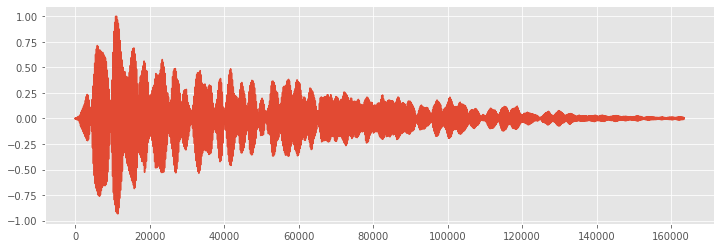

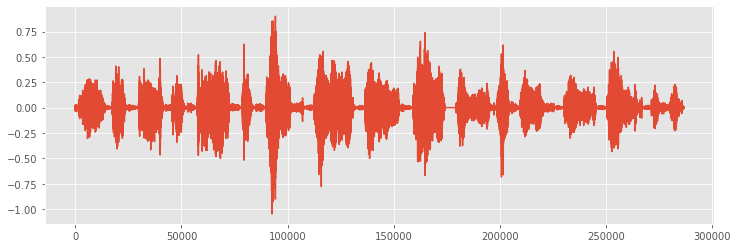

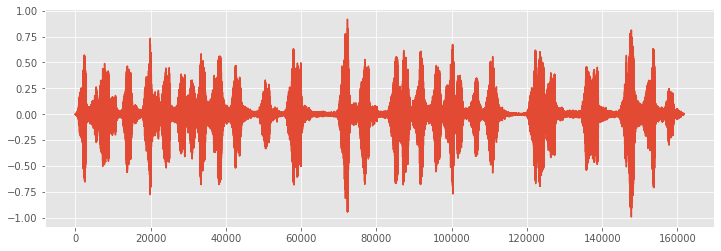

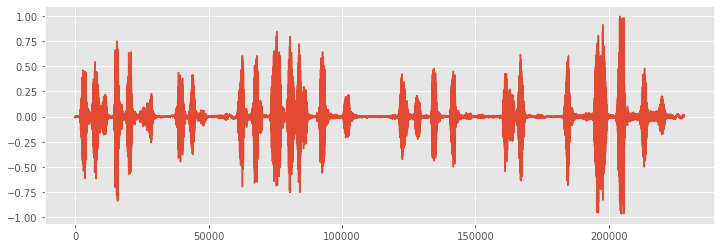

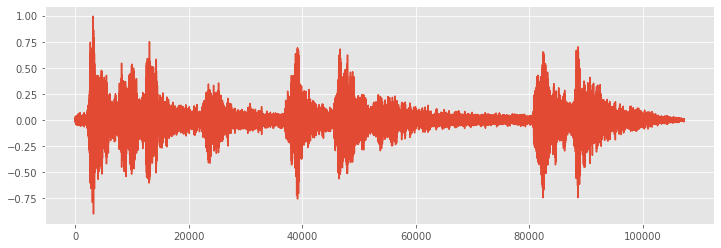

In [117]:
mispredicts= ['./data/kaggle_cats_dogs/cats_dogs/dog_barking_109.wav',
  './data/kaggle_cats_dogs/cats_dogs/dog_barking_18.wav',
  './data/kaggle_cats_dogs/cats_dogs/dog_barking_94.wav',
  './data/kaggle_cats_dogs/cats_dogs/dog_barking_5.wav',
  './data/kaggle_cats_dogs/cats_dogs/dog_barking_112.wav']
for mispredict in mispredicts:
    plot_wav(mispredict)

In [99]:
import IPython.display as ipd
ipd.Audio('./data/kaggle_cats_dogs/cats_dogs/dog_barking_109.wav')

In [103]:
import IPython.display as ipd
ipd.Audio('./data/kaggle_cats_dogs/cats_dogs/dog_barking_18.wav')

In [118]:
import IPython.display as ipd
ipd.Audio('./data/kaggle_cats_dogs/cats_dogs/dog_barking_94.wav')

In [120]:
import IPython.display as ipd
ipd.Audio('./data/kaggle_cats_dogs/cats_dogs/dog_barking_5.wav')

In [121]:
import IPython.display as ipd
ipd.Audio('./data/kaggle_cats_dogs/cats_dogs/dog_barking_112.wav')

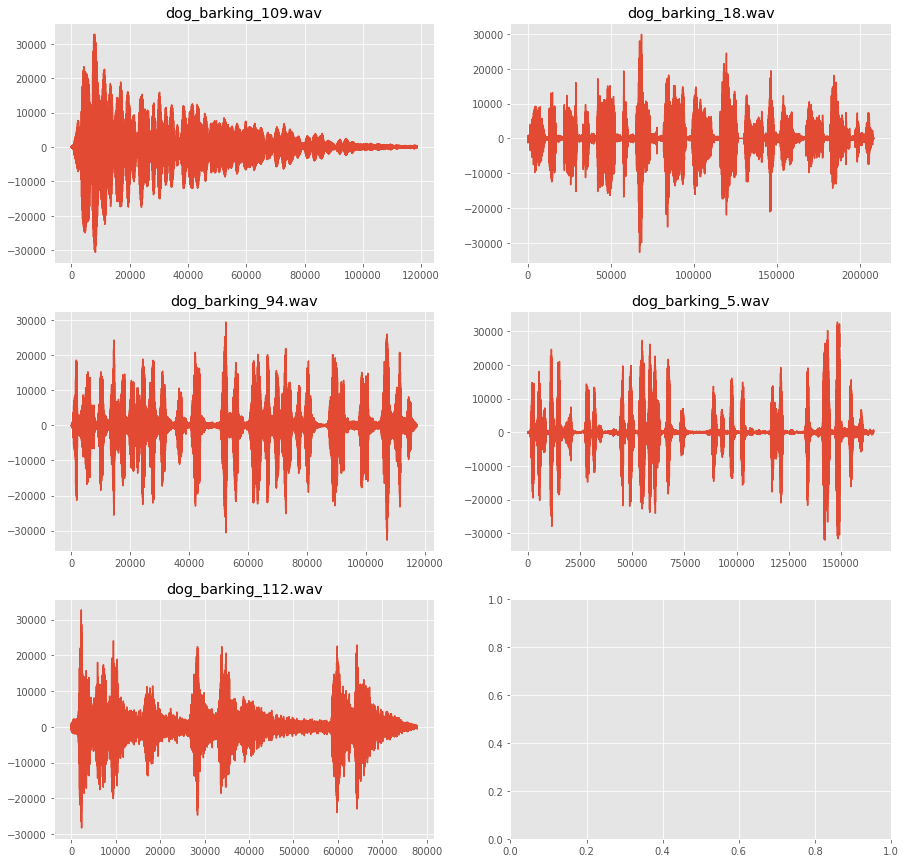

In [133]:
from scipy.io import wavfile as wav

import math
max_rows = math.ceil(len(mispredicts)/2)


fig, axs = plt.subplots(nrows=max_rows, ncols=2, constrained_layout=False)
#fig.suptitle('Visualize Wav Files')
fig.set_size_inches(15, 15)


for i, fn in enumerate(mispredicts):
    row = int(i / 2)
    col = i % 2
    
    # TODO(csaska): need something here
    #fig.add_subplot(5, 2, i+1)
    #plt.title(label)
    
    # Method 1
    #data, sample_rate = librosa.load(fn)
    #librosa.display.waveplot(data, sr= sample_rate)
    
    # Method 2
    #plot_wav(fn)
    
    # Method 3
    librosa_load, librosa_sampling_rate = librosa.load(fn)
    scipy_sampling_rate, scipy_load = wav.read(fn)
    if max_rows == 1:
        #naxs[col].plot(scipy_load)
        #axs[col].set_title(label)
        plot_wav(fn, label)
    else:
        axs[row, col].plot(scipy_load)
        axs[row, col].set_title(os.path.basename(fn).split()[-1])
        
    